# Stack and Test Models

In [1]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
import math
import matplotlib
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

plt.style.use('ggplot')

In [5]:
pd.options.display.max_columns=300 #increase columns shown 

We load the test set

In [10]:
# Load the test set
df = pd.read_csv('./data/new_test.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Load categorical variables
numerical = pickle.load(open('./tmp/numerical.list', 'rb'))
#numerical = list(set(numerical)-set(['SalePrice']))

df.shape

(102600, 82)

In [9]:
df.drop(['Range'], axis=1, inplace=True)

In the train set we noticed that some variables seem to be entered by mistake or represent a very unusual property (i.e. 5000 sq feet garage). We impute the values that differ from the mean by more than 5 standard deviation with the mean.

In [11]:
X=df.copy()

## Predictions using linear models

Load models

In [12]:
models_comb = pickle.load(open('./tmp/models_comb', 'rb'))
models_comb

,model,score
0,model1a,0.000141
1,model1b,0.000174
2,model2a,0.000159
3,model2b,0.000234


### All variables

Linear regression with ridge regularization

In [13]:
model1a = pickle.load(open('./tmp/model1a.model', 'rb'))
model1a

Ridge(alpha=array([0.01005]), copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [14]:
a1 = (model1a.predict(X))
a1.shape

(102600,)

Linear regression with LASSO regularization

In [15]:
model1b = pickle.load(open('./tmp/model1b.model', 'rb'))
model1b

Lasso(alpha=5e-05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [26]:
b1 = (model1b.predict(X))
b1.shape

(102600,)

### Selected variables

Load selected variables

In [18]:
#selected = pickle.load(open('./tmp/feaure_list_dt.list', 'rb'))
#selected
selected = list(['Body', 'TopWick', 'BottomWick','EURVolume','JPYVolume','JPYRange','CHFVolume','CHFRange','XAUVolume', 
                       'XAURange', 'ATR5', 'SAR', 'BBands.dn', 'BBandsm.avg', 'BBands.up'])
selected

['Body',
 'TopWick',
 'BottomWick',
 'EURVolume',
 'JPYVolume',
 'JPYRange',
 'CHFVolume',
 'CHFRange',
 'XAUVolume',
 'XAURange',
 'ATR5',
 'SAR',
 'BBands.dn',
 'BBandsm.avg',
 'BBands.up']

In [19]:
X_sel = X[selected]
X_sel.shape

(102600, 15)

Linear regression with ridge regularization

In [21]:
model2a = pickle.load(open('./tmp/model2a.model', 'rb'))
model2a

Ridge(alpha=array([0.01]), copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [25]:
a2 = (model2a.predict(X_sel))
a2.shape

(102600,)

Linear regression with LASSO regularization

In [28]:
model2b = pickle.load(open('./tmp/model2b.model', 'rb'))
model2b

Lasso(alpha=1.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [29]:
b2 = (model2b.predict(X_sel))
b2.shape

(102600,)

## TreeRegressor

In [30]:
tree = pickle.load(open('./tmp/tree.model', 'rb'))
tree

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [32]:
tr = (tree.predict(X))
tr.shape

(102600,)

## XGB

In [33]:
xgb_mod = pickle.load(open('./tmp/xgb_mod.model', 'rb'))
xgb_mod

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.6, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=nan, n_estimators=50,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

In [34]:
gb = (xgb_mod.predict(X))
gb.shape

(102600,)

## Combining 

Let's comnine all predictions

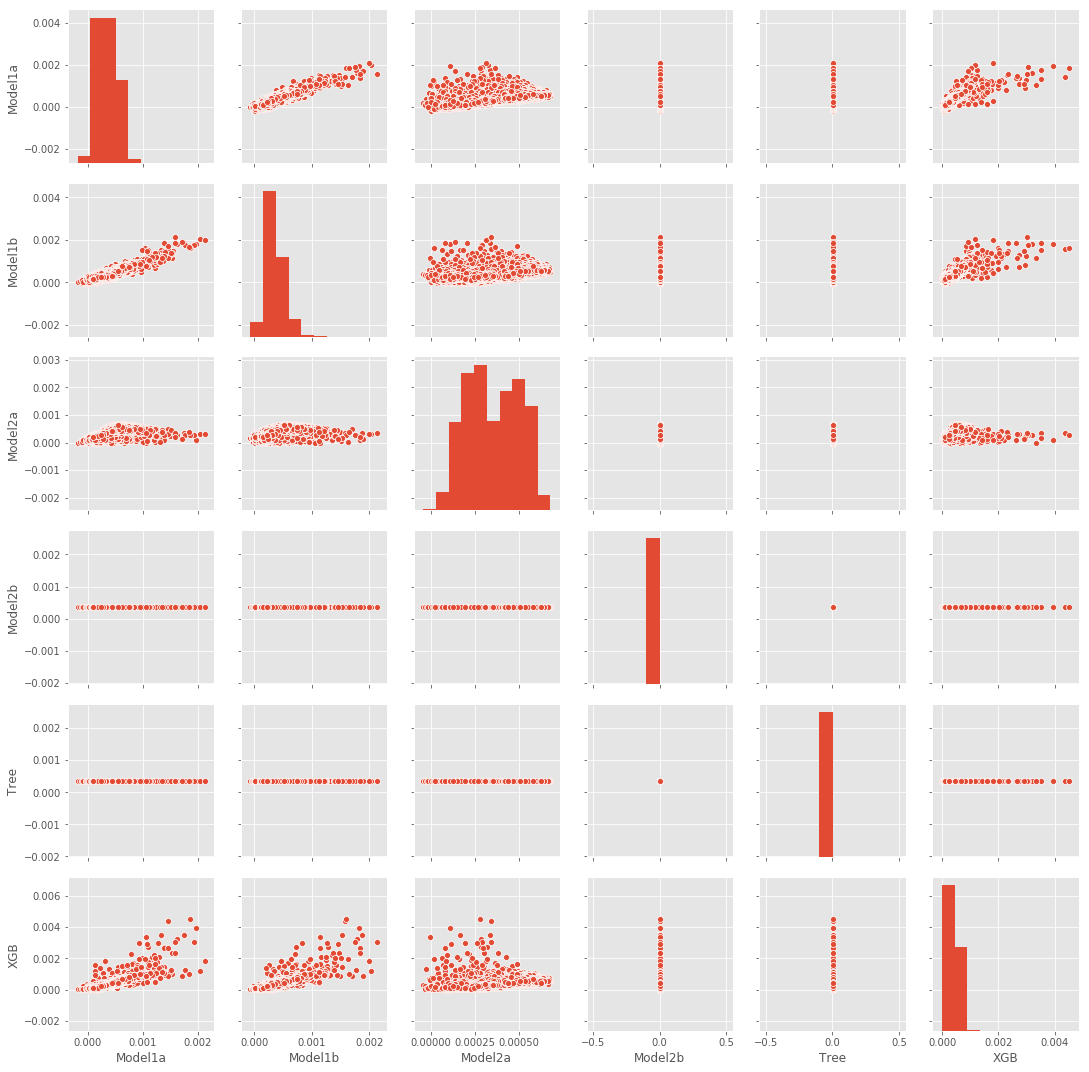

In [35]:
predictions = pd.DataFrame([a1, a2, b1, b2, tr, gb]).T
predictions.columns = ['Model1a', 'Model1b', 'Model2a', 'Model2b', 'Tree', 'XGB']
sns.pairplot(predictions)
plt.savefig('./output/pairwise_predictions.png', dpi=300)

Weighting the predictions.

In [36]:
#Load all models results
tree_comb = pickle.load(open('./tmp/tree_comb', 'rb'))

models = models_comb.append(tree_comb).reset_index().drop('index', axis=1)
models

#Calculate weights
sm = np.sum(1/models['score'])
models['wght'] = models.score.apply(lambda x: (1/x) / sm) # Based on inverse error rate

# Apply weights to predictions
weights = np.array(models['wght']).T
#weights = np.array([0.20, 0.20, 0.20, 0.20, 0, 0, 0.2]).T
pred_mat = np.matrix(predictions)

prediction = weights.dot(pred_mat.T)
prediction.shape

(1, 102600)

We round up predictions to the nearest 1000. Rounding up is chosen for practical reason and because the selected model evaluation critetion (RMSLE) penalizes underestimated values more than overestimated. 

In [21]:
#prediction = np.array(prediction)
#prediction = np.round(prediction / 1000.0) * 1000.0

In [37]:
# Create a dataframe

# Load the test set
df = pd.read_csv('./data/new_test.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

#Reshape prediction

In [38]:
df.head()

,Range,Date,Timestamp,Close,Body,TopWick,BottomWick,EURVolume,JPYClose,JPYRange,JPYVolume,CHFClose,CHFRange,CHFVolume,XAUClose,XAURange,XAUVolume,forceindex,WillR5,WillR10,WillR15,RSI5,RSI10,RSI15,ROC5,ROC10,MOM5,MOM10,ATR5,ATR10,ADX.DIp,ADX.DIn,ADX.DX,ADX,SAR,Stoch.fastK,Stoch.fastD,Stoch.slowD,BBands.dn,BBandsm.avg,BBands.up,BBands.pctB,MACD,MACD.Signal,UpCount_2.0,UpCount_3.0,UpCount_4.0,UpCount_5.0,UpCount_6.0,UpCount_7.0,UpCount_8.0,UpCount_9.0,UpCount_10.0,UpCount_11.0,UpCount_12.0,UpCount_13.0,UpCount_14.0,UpCount_15.0,UpCount_16.0,UpCount_17.0,UpCount_18.0,UpCount_19.0,UpCount_0,DownCount_2.0,DownCount_3.0,DownCount_4.0,DownCount_5.0,DownCount_6.0,DownCount_7.0,DownCount_8.0,DownCount_9.0,DownCount_10.0,DownCount_11.0,DownCount_12.0,DownCount_13.0,DownCount_14.0,DownCount_15.0,DownCount_16.0,DownCount_17.0,DownCount_18.0,DownCount_19.0,DownCount_20.0,DownCount_21.0,DownCount_0,MACD.Signal2_Sell
0,0.00063,2007-09-03,10:42:00,1.36233,0.00010,0.00004,0.00019,6.816298,115.850,0.009950,7.269129,0.792200,0.00020,7.235331,671.345,0.090754,0.005077,0.087241,0.618421,0.654762,0.654762,44.15584,43.97363,45.57762,0.018181,0.010223,0.00025,0.00014,0.00033,0.00033,4.122643,9.864302,3.738862,3.141767,1.362814,0.345238,0.329285,0.352987,1.362242,1.362447,1.362652,0.173069,0.001292,0.000371,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.00058,2007-01-08,17:11:00,1.30221,0.00006,0.00007,0.00010,6.740992,118.758,0.036332,5.730749,0.804702,0.00025,5.548687,608.923,0.517006,0.016316,0.049479,0.368421,0.297872,0.254545,61.32075,63.88889,59.11215,0.002301,0.017511,0.00003,0.00023,0.00023,0.00023,9.437096,13.990470,3.017297,3.137782,1.301880,0.745455,0.731421,0.696129,1.301956,1.302112,1.302268,0.717680,0.002069,0.001368,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.00033,2007-10-17,10:26:00,1.42173,0.00022,0.00018,0.00007,7.060691,116.630,0.029559,7.550872,0.779050,0.00020,7.300473,760.591,0.287432,0.005863,0.228040,0.273973,0.246914,0.227273,59.81013,56.02837,56.55696,0.006311,0.017434,0.00009,0.00025,0.00047,0.00047,7.328730,10.270220,2.874355,2.841387,1.421184,0.772727,0.712364,0.709458,1.421295,1.421520,1.421745,0.885863,0.002130,0.000834,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.00028,2007-03-15,09:35:00,1.32241,0.00018,0.00004,0.00002,6.769297,117.174,0.027615,5.349961,0.796069,0.00039,4.304065,644.639,0.630207,0.025073,0.145438,0.607843,0.789474,0.878788,51.45631,37.19943,33.41609,0.006782,0.031256,0.00009,0.00042,0.00024,0.00024,20.882360,26.297180,2.523891,2.353964,1.323391,0.121212,0.103988,0.115747,1.321889,1.322747,1.323605,0.272412,0.002032,0.004607,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0.00027,2007-07-02,01:58:00,1.35387,0.00006,0.00000,0.00000,5.777652,123.000,0.009950,5.350435,0.798318,0.00010,5.826885,648.741,0.192272,0.003474,0.019136,0.808511,0.550725,0.457831,17.44966,45.80537,54.78469,0.018294,0.016122,0.00025,0.00022,0.00009,0.00009,30.228800,26.421240,2.043969,3.133571,1.354250,0.542169,0.597550,0.670144,1.353266,1.353745,1.354223,0.651923,0.007311,0.006227,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
prediction = np.array(prediction)

In [55]:

submission = pd.DataFrame({'Date':df['Date'], 'Timestamp':df['Timestamp'], 'Predicted': prediction[0,:]})

submission.head()


,Date,Predicted,Timestamp
0,2007-09-03,0.000394,10:42:00
1,2007-01-08,0.000318,17:11:00
2,2007-10-17,0.000467,10:26:00
3,2007-03-15,0.000286,09:35:00
4,2007-07-02,0.000173,01:58:00


## Use real data

We find the answer key in R package https://cran.r-project.org/web/packages/AmesHousing/index.html

In [56]:
# Load answer key
answer = df[['Date','Timestamp','Range']]
answer.head()

,Date,Timestamp,Range
0,2007-09-03,10:42:00,0.00063
1,2007-01-08,17:11:00,0.00058
2,2007-10-17,10:26:00,0.00033
3,2007-03-15,09:35:00,0.00028
4,2007-07-02,01:58:00,0.00027


In [57]:
# Merge with prediction

result = pd.merge(answer, submission, on=['Date', 'Timestamp'])
result

,Date,Timestamp,Range,Predicted
0,2007-09-03,10:42:00,0.00063,0.000394
1,2007-01-08,17:11:00,0.00058,0.000318
2,2007-10-17,10:26:00,0.00033,0.000467
3,2007-03-15,09:35:00,0.00028,0.000286
4,2007-07-02,01:58:00,0.00027,0.000173
5,2007-02-15,14:25:00,0.00049,0.000338
6,2007-12-12,03:06:00,0.00071,0.000663
7,2007-01-31,00:39:00,0.00038,0.000319
8,2007-07-02,04:38:00,0.00018,0.000198
9,2007-11-02,04:13:00,0.00059,0.000531


We greaphically analyze our predictions

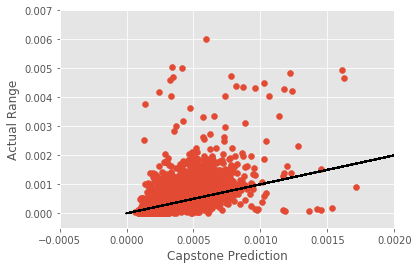

In [61]:
#Plot 

plt.scatter(result['Predicted'], result['Range'])
plt.plot(result['Range'], result['Range'], c='black')
plt.ylabel('Actual Range')
plt.xlabel('Capstone Prediction')
plt.xlim((-0.0005, 0.002))
plt.ylim((-0.0005, 0.007))
plt.savefig('./output/true_vs_pred_consensus.png', dpi=300)

We calculate RMSLE using natural logarithm of prices

In [62]:
rmsle = np.sqrt(np.mean(((result['Range']) - (result['Predicted']))**2))
rmsle

0.00015456021268930682

... and the logarithm with base 10.

In [65]:
rmsle10 = np.sqrt(np.mean(((result['Range']) - (result['Predicted']))**2))
rmsle10

0.00015456021268930682

## Let's see how each model performed

In [73]:
def rmsl_test(x,y):
    return (np.sqrt(np.mean(((x)-(y))**2)))

tmp_= result.join(predictions)

for i in range(3,10):
    y = tmp_.Range
    x = tmp_.iloc[:,i]
    
    print(tmp_.columns.values[i], ":", rmsl_test(x,y))

Predicted : 0.00015456021268930682
Model1a : 0.00014182746745190585
Model1b : 0.00015788111311996927
Model2a : 0.00017368420416903656
Model2b : 0.00023340845995637144
Tree : 0.0002334081691001561
XGB : 0.00014161461638349243
